In [ ]:
train_dir = 'pig_pic_src/train/'
valid_dir = 'pig_pic_src/valid/'

processed_train_dir = 'pig_pic_src_processed/train/'
processed_valid_dir = 'pig_pic_src_processed/valid/'

from jpg_data_preprocess import *

preprocess_all_pics(valid_dir, processed_valid_dir, train = False)
preprocess_all_pics(train_dir, processed_train_dir, data_plus = 10, train = True)

pig_pic_src/valid/01.pig -> pig_pic_src_processed/valid/01.pig#  start process
3 images processed
pig_pic_src/valid/02.pig -> pig_pic_src_processed/valid/02.pig#  start process
5 images processed
pig_pic_src/valid/03.pig -> pig_pic_src_processed/valid/03.pig#  start process
4 images processed
pig_pic_src/valid/04.pig -> pig_pic_src_processed/valid/04.pig#  start process
4 images processed
pig_pic_src/valid/05.pig -> pig_pic_src_processed/valid/05.pig#  start process
3 images processed
pig_pic_src/valid/06.pig -> pig_pic_src_processed/valid/06.pig#  start process
5 images processed
pig_pic_src/valid/07.pig -> pig_pic_src_processed/valid/07.pig#  start process
4 images processed
pig_pic_src/valid/08.pig -> pig_pic_src_processed/valid/08.pig#  start process
5 images processed
pig_pic_src/valid/09.pig -> pig_pic_src_processed/valid/09.pig#  start process
5 images processed
pig_pic_src/valid/10.pig -> pig_pic_src_processed/valid/10.pig#  start process
4 images processed
pig_pic_src/valid/11

Using TensorFlow backend.


Found 1235 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
(16, 299, 299, 3)


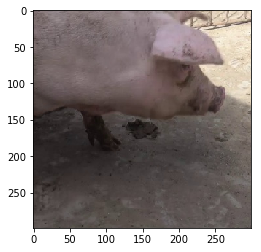

In [3]:
## 准备图片数据
train_data_dir = "E:/PROJECT/Competition/TogithubTransfer/pig_pic_src_processed/train"
validation_data_dir = "E:/PROJECT/Competition/TogithubTransfer/pig_pic_src_processed/valid"
img_width, img_height = 299, 299
###
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import skimage
import skimage.io
import skimage.transform

from scipy.ndimage import imread


train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='categorical',
        shuffle=True)

valid_generator = train_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=16,
        class_mode='categorical',
        shuffle=True)

%matplotlib inline
import matplotlib.pyplot as plt

for x_batch, y_batch in train_generator:
    print(x_batch.shape)
    plt.imshow(x_batch[0])
    plt.show()
    #print(x_batch[0][0])
    break

In [10]:
### 
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D,Dropout
from keras import regularizers,initializers
from keras.models import Model
print("1")
from keras.applications.inception_resnet_v2  import InceptionResNetV2   #Xception
print("2")
model = InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (img_width, img_height,3))
print("build model")
#model.load_weights("inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5")

# “小网络”结构
x = model.output
x = Flatten(input_shape=model.output_shape[1:])(x)
x = Dense(128, activation='relu', name='fc2',kernel_regularizer=regularizers.l2(0.01))(x)   
predictions = Dense(2, activation='softmax')(x)
# 两个网络整合
vgg_model = Model(input=model.input, output=predictions)
print("merge")
vgg_model.summary()
print("completed")

1
2
build model
merge
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
_______________________________________________________________________________________

D:\Users\XX\Anaconda2\envs\gpu-env-tf-keras\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`



block35_3 (Lambda)              (None, 35, 35, 320)  0           block35_2_ac[0][0]               
                                                                 block35_3_conv[0][0]             
__________________________________________________________________________________________________
block35_3_ac (Activation)       (None, 35, 35, 320)  0           block35_3[0][0]                  
__________________________________________________________________________________________________
conv2d_237 (Conv2D)             (None, 35, 35, 32)   10240       block35_3_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_237 (BatchN (None, 35, 35, 32)   96          conv2d_237[0][0]                 
__________________________________________________________________________________________________
activation_237 (Activation)     (None, 35, 35, 32)   0           batch_normalization_237[0][0]    
_________

In [11]:
### 冻结权重
for layer in vgg_model.layers[:438]:
    layer.trainable = False
###
vgg_model.compile(loss='categorical_crossentropy', optimizer='Adam', # sgd  Adadelta  RMSprop Adadelta
                  metrics=['accuracy'])


In [ ]:
from keras.callbacks import ModelCheckpoint 
# train the model
epochs = 10
nb_train_samples = 4886
nb_validation_samples = 119

batch_size = 2
#
checkpointer = ModelCheckpoint(filepath='vgg16.weights.best.hdf5', verbose=1, #Xcp
                               save_best_only=True)
vgg_model.fit_generator(train_generator, steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=valid_generator,
        validation_steps=nb_validation_samples // batch_size,
        callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/10
